In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.nn import NeuralNetwork

random_seed = 37 # fave number wooo
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
positive_seqs = read_text_file('data/rap1-lieb-positives.txt')
print(f"Number of positive sequences: {len(positive_seqs)}")
print(f"Example positive sequence: {positive_seqs[0]}")
print(f"Length of positive sequences: {len(positive_seqs[0])}")

negative_seqs_raw = read_fasta_file('data/yeast-upstream-1k-negative.fa')
print(f"Number of negative sequences: {len(negative_seqs_raw)}")
print(f"Example negative sequence (first 50 bp): {negative_seqs_raw[0][:50]}")
print(f"Length of negative sequences: {len(negative_seqs_raw[0])}")

# Extract random subsequences of the same length as positive sequences
pos_seq_length = len(positive_seqs[0])
negative_seqs = []

for seq in negative_seqs_raw:
    if len(seq) >= pos_seq_length:
        # This increases our negative examples dataset
        for i in range(0, len(seq) - pos_seq_length, pos_seq_length):
            subsequence = seq[i:i + pos_seq_length]
            negative_seqs.append(subsequence)
print(f"Number of processed negative sequences: {len(negative_seqs)}")

Number of positive sequences: 137
Example positive sequence: ACATCCGTGCACCTCCG
Length of positive sequences: 17
Number of negative sequences: 3163
Example negative sequence (first 50 bp): CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATCAAAC
Length of negative sequences: 1000
Number of processed negative sequences: 183296


In [3]:
# Create labels and combine with sequences
positive_labels = [True] * len(positive_seqs)
negative_labels = [False] * len(negative_seqs)
all_seqs = positive_seqs + negative_seqs
all_labels = positive_labels + negative_labels
print(f"Total sequences before balancing: {len(all_seqs)}")
print(f"Class distribution before balancing: Positive={len(positive_seqs)}, Negative={len(negative_seqs)}")

# Balance the classes
balanced_seqs, balanced_labels = sample_seqs(all_seqs, all_labels)
print(f"Total sequences after balancing: {len(balanced_seqs)}")
print(f"Class distribution after balancing: Positive={sum(balanced_labels)}, Negative={len(balanced_labels) - sum(balanced_labels)}")

# One-hot encode the sequences
X = one_hot_encode_seqs(balanced_seqs)
y = np.array(balanced_labels).reshape(-1, 1)  # Reshape for the neural network
print(f"Input shape after one-hot encoding: {X.shape}")
print(f"Expected shape: ({len(balanced_seqs)}, {pos_seq_length * 4})")

# train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Total sequences before balancing: 183433
Class distribution before balancing: Positive=137, Negative=183296
Total sequences after balancing: 366592
Class distribution after balancing: Positive=183296, Negative=183296
Input shape after one-hot encoding: (366592, 68)
Expected shape: (366592, 68)
Training set size: 293273
Validation set size: 73319


In [4]:
nn_architecture = [
    {'input_dim': pos_seq_length * 4, 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}
]

# Hyperparameters
learning_rate = 0.001
seed = random_seed
batch_size = 16
epochs = 30
loss_function = 'binary_cross_entropy'

# Initialize the classifier
classifier = NeuralNetwork(
    nn_arch=nn_architecture,
    lr=learning_rate,
    seed=seed,
    batch_size=batch_size,
    epochs=epochs,
    loss_function=loss_function
)

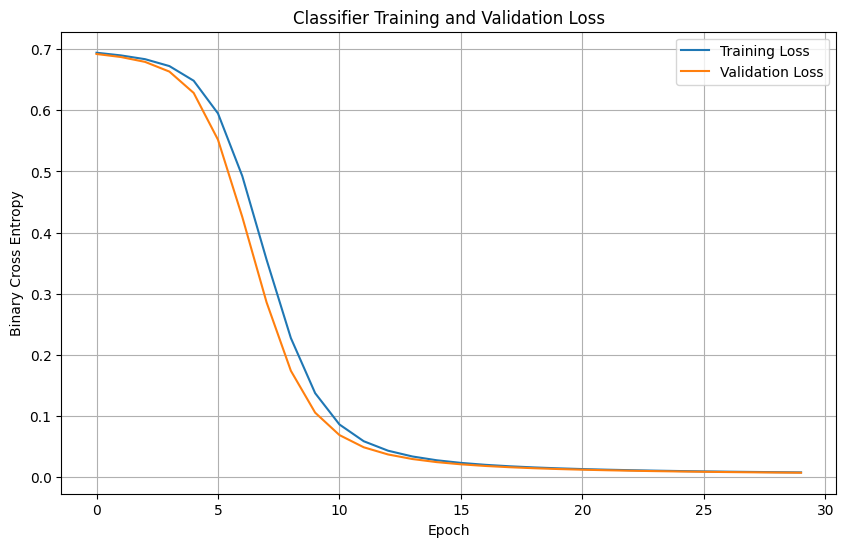

In [5]:
# Train the classifier
train_losses, val_losses = classifier.fit(X_train, y_train, X_val, y_val)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.title('Classifier Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# validate validate validaaatttee
y_hat_val = classifier.predict(X_val)
y_hat_val = y_hat_val.T  # Convert to original shape

# probabilities --> predictions (aka rounding)
y_pred_val = (y_hat_val > 0.5).astype(int)
accuracy = np.mean(y_pred_val == y_val)
print(f"Validation accuracy: {accuracy:.4f}")

Validation accuracy: 0.9988


In [7]:
# Evaluation: Precision, recall, f1score
true_positives = np.sum((y_val == 1) & (y_pred_val == 1))
false_positives = np.sum((y_val == 0) & (y_pred_val == 1))
false_negatives = np.sum((y_val == 1) & (y_pred_val == 0))

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.9976
Recall: 1.0000
F1 Score: 0.9988


## Sampling Scheme Explanation:

To address the significant class imbalance between positive and negative examples in the original dataset, I used a balanced sampling approach.

1. I extracted subsequences from negative examples matching the length of positive examples.
2. I used random sampling with replacement to upsample the minority class (positive examples).
3. This resulted in an equal number of positive and negative examples.
4. I shuffled the data to ensure random ordering of examples during training.

This balanced approach prevents the model from biasing toward the majority class and ensures the classifier learns from both classes equally.

## Hyperparameter Choices:

1. Network Architecture:
   - Input layer matches the one-hot encoded DNA sequence length (`pos_seq_length` * 4)
   - Two hidden layers (32, 16 neurons) provide sufficient capacity to learn sequence patterns
   -  Sigmoid activation output layer provides classification probabilities

2. Learning Rate (0.001):
   - Small learning rate but still converges quickly
   - Prevents jumping around the actual minimum during training

3. Batch Size (16):
   - Smaller than autoencoder to provide more frequent parameter updates
   - Helps avoid overfitting, which is a real issue here bc of the limited number of positive examples
   - Balances computational efficiency and learning dynamic

4. Epochs (30):
   - started with 50, but I saw that convergence occurred by 30 epochs
   - no overfitting (loss between train and val is remarkably similar after convergence)

5. Loss Function (Binary Cross Entropy):
   - Standard loss function for binary classification

